In [35]:
# Jupyter Notebook
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import pygrib
import pyart
import plotly.express as px
from datetime import datetime
import gzip
import shutil
import numpy as np

In [36]:
# Base URL for your Flask API
base_url = 'http://127.0.0.1:5000'

# Function to fetch NEXRAD data
def fetch_nexrad_data(start, end, station):
    response = requests.get(f'{base_url}/nexrad', params={
        'start_year': start.year, 'start_month': start.month, 'start_day': start.day,
        'start_hour': start.hour, 'start_minute': start.minute,
        'end_year': end.year, 'end_month': end.month, 'end_day': end.day,
        'end_hour': end.hour, 'end_minute': end.minute,
        'station': station
    })
    return response.json()

# Function to fetch MRMS data
def fetch_mrms_data(subdir, max_files=1):
    response = requests.get(f'{base_url}/mrms/{subdir}', params={'max_files': max_files})
    return response.json()

# Function to fetch GOES data
def fetch_goes_data(start, end, product='ABI-L2-ACHAC'):
    response = requests.get(f'{base_url}/goes', params={
        'start_year': start.year, 'start_month': start.month, 'start_day': start.day,
        'start_hour': start.hour, 'start_minute': start.minute,
        'end_year': end.year, 'end_month': end.month, 'end_day': end.day,
        'end_hour': end.hour, 'end_minute': end.minute,
        'product': product
    })
    return response.json()

# Function to fetch Weather Alert data
def fetch_alert_data():
    response = requests.get(f'{base_url}/weather-alerts')
    return response.json()['features']



# NEXRAD Visualization
def visualize_nexrad(file_path):

    radar = pyart.io.read_nexrad_archive(os.path.join('./data/nexrad/',file_path))
    display = pyart.graph.RadarMapDisplay(radar)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    # Set extent based on radar location
    lon_center = radar.longitude['data'][0]
    lat_center = radar.latitude['data'][0]
    ax.set_extent([lon_center - 5, lon_center + 5, lat_center - 5, lat_center + 5], crs=ccrs.PlateCarree())
    display.plot_ppi_map('reflectivity', 0, vmin=-32, vmax=64, ax=ax)
    # ax.set_extent([-130, -65, 20, 50], ccrs.Geodetic())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    plt.title('NEXRAD Data Visualization')
    plt.show()

def decompress_grib(gz_path, decompressed_path):
    with gzip.open(gz_path, 'rb') as f_in:
        with open(decompressed_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

def visualize_mrms(mrms_grib_path):
    decompressed_path = mrms_grib_path[:-3]  # Remove .gz extension
    decompress_grib(mrms_grib_path, decompressed_path)
    
    grbs = pygrib.open(decompressed_path)
    grb = grbs.message(1)
    data = grb.values
    lats, lons = grb.latlons()
    
    with np.errstate(invalid='ignore'):
        data = np.log(data + 1e-10)
    
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), cmap='GnBu')
    
    plt.title('MRMS Data Visualization')
    plt.show()

# GOES Visualization
def visualize_goes(goes_file_path):
    ds = xr.open_dataset(goes_file_path)
    img_data = ds['HT'].data
    
    fig = px.imshow(img_data, origin='lower', color_continuous_scale='gray')
    fig.update_layout(title='GOES Data Visualization')
    fig.show()




In [37]:
# Example dates and station
start_date = datetime(2024, 5, 1, 0, 0)
end_date = datetime(2024, 5, 1, 1, 0)
station = 'KTLX'
precip_subdir = 'PrecipRate'
reflectivity_subdir = 'Reflectivity_0C'

## Nexrad viz example

In [38]:
nexrad_data = fetch_nexrad_data(start_date, end_date, station)

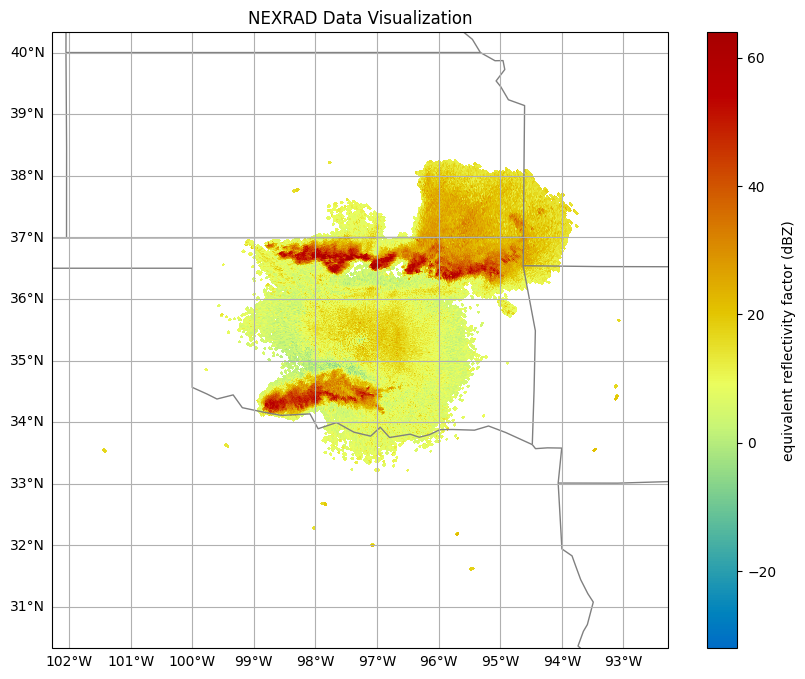

In [39]:
visualize_nexrad(nexrad_data['files'][0])

## MRMS viz example - PrecipRate

In [40]:
mrms_data = fetch_mrms_data(precip_subdir)

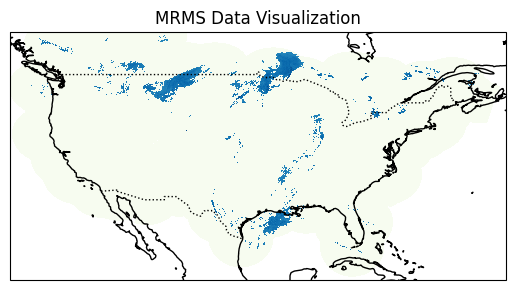

In [41]:
visualize_mrms(mrms_data['files'][0])

## MRMS viz example - Reflectivity

In [42]:
mrms_data = fetch_mrms_data(reflectivity_subdir)

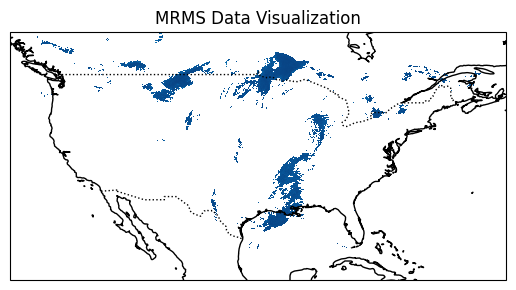

In [43]:
visualize_mrms(mrms_data['files'][0])

## GOES viz example

In [44]:
goes_data = fetch_goes_data(start_date, end_date)

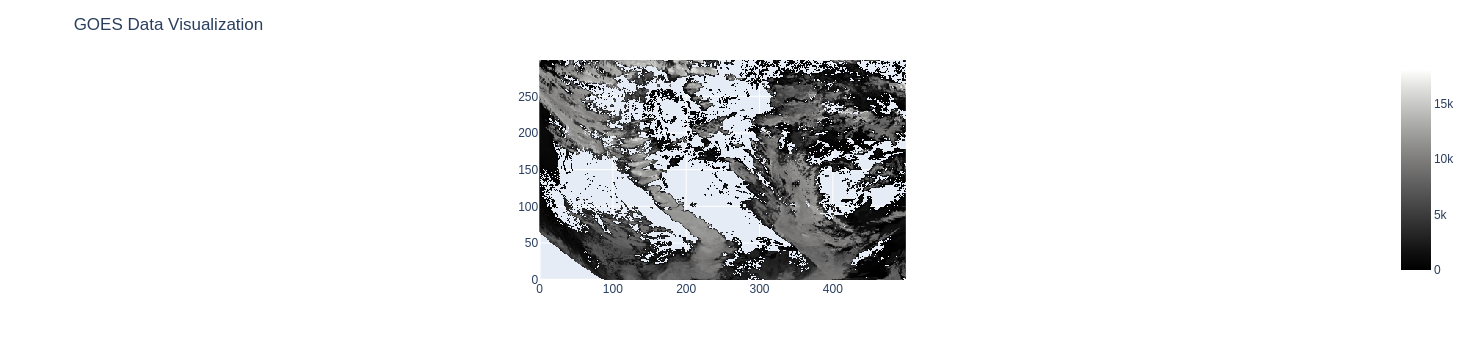

In [45]:
visualize_goes(goes_data['files'][0])

## Weather Alerts

In [46]:
alerts = fetch_alert_data()

In [47]:
alerts[0]

{'geometry': {'coordinates': [[[-95.44, 32.05],
    [-95.24, 31.669999999999998],
    [-95.36999999999999, 31.659999999999997],
    [-95.43999999999998, 31.799999999999997],
    [-95.47999999999999, 31.879999999999995],
    [-95.44, 32.05]]],
  'type': 'Polygon'},
 'id': 'https://api.weather.gov/alerts/urn:oid:2.49.0.1.840.0.9a0aab6606ddcd54ecee3cf241858c6be32be1bb.001.1',
 'properties': {'@id': 'https://api.weather.gov/alerts/urn:oid:2.49.0.1.840.0.9a0aab6606ddcd54ecee3cf241858c6be32be1bb.001.1',
  '@type': 'wx:Alert',
  'affectedZones': ['https://api.weather.gov/zones/county/TXC001',
   'https://api.weather.gov/zones/county/TXC073',
   'https://api.weather.gov/zones/county/TXC225'],
  'areaDesc': 'Anderson, TX; Cherokee, TX; Houston, TX',
  'category': 'Met',
  'certainty': 'Observed',
  'description': '...The Flood Warning continues for the following rivers in Texas...\n\nNeches River Near Neches affecting Anderson, Houston and Cherokee\nCounties.\n\nFor the Neches River...including